In [43]:
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

In [44]:
# define a timer class to record time
class Timer(object):
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        # start the timer
        self.start_time = time.time()

    def stop(self):
        # stop the timer and record time into a list
        self.times.append(time.time() - self.start_time)
        return self.times[-1]

    def avg(self):
        # calculate the average and return
        return sum(self.times)/len(self.times)

    def sum(self):
        # return the sum of recorded time
        return sum(self.times)

In [45]:
# 1、线性回归普通实现：
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4] # 只暂时作用于 生成目标Y
true_b = 4.2 # 只暂时作用于 生成目标Y
features = torch.randn(num_examples, num_inputs, dtype=torch.float32)
#  生成目标Y：Y = Xw + b + ε = 没用矩阵乘法，是单向量乘
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
# 再 + ε误差
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()),dtype=torch.float32)

In [46]:
print(features[0], labels[0], features.shape, labels.shape)

tensor([0.1451, 1.4294]) tensor(-0.3737) torch.Size([1000, 2]) torch.Size([1000])


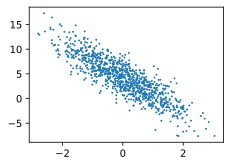

In [47]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg') 

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

# # 在../d2lzh_pytorch里面添加上面两个函数后就可以这样导入
# import sys
# sys.path.append("..")
# from d2lzh_pytorch import * 

set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);

In [48]:
# 读取数据
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # 最后一次可能不足一个batch
        yield  features.index_select(0, j), labels.index_select(0, j) # 必须用 yield；index_select(轴，索引)

In [49]:
batch_size = 10

i = 0
for X, y in data_iter(batch_size, features, labels):
    i += 1
    print(X, y)
    if i == 2:
        break

tensor([[ 2.0072, -0.5129],
        [-0.0400, -0.8009],
        [ 0.3602, -0.2007],
        [ 1.0240, -0.9829],
        [ 0.5389, -1.3935],
        [ 1.6549,  0.7091],
        [ 0.0138,  1.2828],
        [ 0.5857,  2.0151],
        [ 0.0175, -1.5000],
        [ 0.3546,  0.9663]]) tensor([ 9.9689,  6.8504,  5.5917,  9.5931, 10.0130,  5.1100, -0.1454, -1.4692,
         9.3486,  1.6377])
tensor([[ 1.2578, -1.0889],
        [ 1.4017,  0.2224],
        [ 1.3563, -0.9385],
        [-0.6194,  0.2399],
        [-1.5520, -2.1374],
        [ 1.5807,  1.2765],
        [ 2.8589,  0.1972],
        [ 0.4821, -0.6832],
        [-2.8051,  1.7975],
        [ 0.5037, -0.5273]]) tensor([10.4116,  6.2380, 10.1010,  2.1431,  8.3718,  3.0102,  9.2420,  7.4879,
        -7.5051,  6.9937])


In [50]:
# 初始化模型参数
# 均值为0、标准差为0.01的正态随机数
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32) # 偏差则初始化成0
print(w.shape, w.size(), w.dim(), len(w.shape))
print(b.shape, b.size(), b.dim(), len(b.shape))

torch.Size([2, 1]) torch.Size([2, 1]) 2 2
torch.Size([1]) torch.Size([1]) 1 1


In [51]:
# 之后的模型训练中，需要对这些参数求梯度来迭代参数的值，因此我们要让它们的requires_grad=True
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True) 

tensor([0.], requires_grad=True)

In [52]:
# 模型
def linreg(X, w, b):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    return torch.mm(X, w) + b

In [66]:
# 损失函数
def squared_loss(y_hat, y):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    # 注意这里返回的是向量, 另外, pytorch里的MSELoss并没有除以 2
    # y_hat：torch.Size([10, 1])  y：torch.Size([10])
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

In [54]:
# 梯度计算
def sgd(params, lr, batch_size):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    for param in params:
        param.data -= lr * param.grad / batch_size # 注意这里更改param时用的param.data

In [67]:
# super parameters init
lr = 0.03
num_epochs = 1 # 5

net = linreg
loss = squared_loss

# training
for epoch in range(num_epochs):  # training repeats num_epochs times
    # in each epoch, all the samples in dataset will be used once
    
    # X is the feature and y is the label of a batch sample
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()  
        # calculate the gradient of batch sample loss 
        l.backward()  
        # using small batch random gradient descent to iter model parameters
        sgd([w, b], lr, batch_size)  
        # reset parameter gradient
        w.grad.data.zero_() # 不理解这里的意思
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.000048


In [26]:
w, true_w, b, true_b

(tensor([[ 2.0004],
         [-3.3999]], requires_grad=True),
 [2, -3.4],
 tensor([4.1994], requires_grad=True),
 4.2)

In [29]:
# 2、线性回归模型使用pytorch的简洁实现
import torch
from torch import nn
import numpy as np
torch.manual_seed(1)

print(torch.__version__)
torch.set_default_tensor_type('torch.FloatTensor')

1.2.0


In [30]:
num_inputs = 2
num_examples = 1000

true_w = [2, -3.4]
true_b = 4.2

features = torch.tensor(np.random.normal(0, 1, (num_examples, num_inputs)), dtype=torch.float)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

In [31]:
import torch.utils.data as Data

batch_size = 10

# combine featues and labels of dataset
dataset = Data.TensorDataset(features, labels)

# put dataset into DataLoader
data_iter = Data.DataLoader(
    dataset=dataset,            # torch TensorDataset format
    batch_size=batch_size,      # mini batch size
    shuffle=True,               # whether shuffle the data or not
    num_workers=2,              # read data in multithreading
)

In [32]:
for X, y in data_iter:
    print(X, '\n', y)
    break

tensor([[ 0.6422,  1.2470],
        [ 0.7098,  0.1390],
        [ 0.5152, -0.2208],
        [-0.7491,  0.4660],
        [ 1.1578, -0.1614],
        [-1.9224,  2.5455],
        [-0.7821, -1.7002],
        [-0.7603,  0.3855],
        [ 0.0088, -0.0038],
        [ 1.1764, -0.9523]]) 
 tensor([ 1.2481,  5.1383,  5.9945,  1.1115,  7.0572, -8.2947,  8.4154,  1.3570,
         4.2321,  9.7821])


In [33]:
class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super(LinearNet, self).__init__()      # call father function to init 
        self.linear = nn.Linear(n_feature, 1)  # function prototype: `torch.nn.Linear(in_features, out_features, bias=True)`

    def forward(self, x):
        y = self.linear(x)
        return y
    
net = LinearNet(num_inputs)
print(net)

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


In [34]:
# ways to init a multilayer network（额外的功能：多层网络示例）
# method one
net = nn.Sequential(
    nn.Linear(num_inputs, 1)
    # other layers can be added here
    )

# method two
net = nn.Sequential()
net.add_module('linear', nn.Linear(num_inputs, 1))
# net.add_module ......

# method three
from collections import OrderedDict
net = nn.Sequential(OrderedDict([
          ('linear', nn.Linear(num_inputs, 1))
          # ......
        ]))

print(net)
print(net[0])

Sequential(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Linear(in_features=2, out_features=1, bias=True)


In [35]:
# 初始化模型参数
from torch.nn import init

init.normal_(net[0].weight, mean=0.0, std=0.01)
init.constant_(net[0].bias, val=0.0)  # or you can use `net[0].bias.data.fill_(0)` to modify it directly

Parameter containing:
tensor([0.], requires_grad=True)

In [36]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[-0.0142, -0.0161]], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)


In [37]:
# 定义损失函数
loss = nn.MSELoss()    # nn built-in squared loss function
                       # function prototype: `torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean')`

In [38]:
# 定义优化函数
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.03)   # built-in random gradient descent function
print(optimizer)  # function prototype: `torch.optim.SGD(params, lr=, momentum=0, dampening=0, weight_decay=0, nesterov=False)`

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [39]:
num_epochs = 3
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        output = net(X)
        l = loss(output, y.view(-1, 1))
        optimizer.zero_grad() # reset gradient, equal to net.zero_grad()
        l.backward()
        optimizer.step()
    print('epoch %d, loss: %f' % (epoch, l.item()))

epoch 1, loss: 0.000354
epoch 2, loss: 0.000104
epoch 3, loss: 0.000233


In [40]:
# result comparision
dense = net[0]
print(true_w, dense.weight.data)
print(true_b, dense.bias.data)

[2, -3.4] tensor([[ 1.9993, -3.3995]])
4.2 tensor([4.2000])
